<a href="https://colab.research.google.com/github/AlexSchma/DL_Gr13/blob/main/DL_Ass3B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3B:** Implementing recurrent neural networks in PyTorch

**Goal:** Implement recurrent neural networks (RNNs) in PyTorch.

**Submission:** As before, provide a PDF that directly answers each question, and use the provided report template. This is a group exercise. As a result, the amount of work is a little higher, so make sure to collaborate efficiently.

In this assignment, we will look at RNNs. As before, answer all explicitly labeled questions.

There are a few additional questions in the text of the exercise but these are meant for reflection only. Discuss them in the text of your report if it makes sense, but otherwise, just make sure you can answer them for yourself.

**New datasets.** Install the the wget module in your python environment with the command

`pip install wget`

and then download the following dataset script: https://gist.github.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c

Like the dataset script of assignment 1, this contains basic functions for loading various datasets.

## **Part 1:** Classification: data loading

The IMDb dataset is the sequence-learning equivalent of MNIST: a large, challenging classification dataset with plenty of examples, that is still light enough to train models for on a laptop. It contains 50 000 reviews of movies, taken from the Internet Movie Database which are either highly positive or highly negative. The task is to predict which for a given review. This is known as sentiment analysis.

If this seems like a simple task, note that even large pretrained models like ELMo don't get far over 95% accuracy, so this is by no means a solved or a toy problem.

To simplify things, we've preprocessed and tokenized the data for you. Our tokenization is a little crude: we lowercase everything, remove all non-letters and split on whitespace. It'll do for our current purposes, but in practice, you'd look to more refined tokenization strategies to extract more information from the raw text. All words have been converted to integer indices in a fixed vocabulary.
To load the data, call the load_imdb function as follows:

In [ ]:
%pip install wget

In [10]:
import data_rnn

(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = data_rnn.load_imdb(final=False)


The return values are as follows:


*   `x_train`: A python list of lists of integers. Each integer represents a word. Sorted
from short to long.
*   `y_train`: The corresponding class labels: 0 for positive, 1 for negative.
*   `x_val`: Test/validation data. Laid out the same as x_train.
*   `y_val`: Test/validation labels
*   `i2w`: A list of strings mapping the integers in the sequences to their original words.
`i2w[141]` returns the string containing word 141.
*   `w2i`: A dictionary mapping the words to their indices. `w2i['film']` returns the index
for the word "film".

If `final` is true, the function returns the canonical test/train split with 25 000 reviews in each. If `final` is false, a validation split is returned with 20 000 training instances and 5 000 validation instances.

To have a look at your data (always a good idea), you can convert a sequence from indices to words as follows:

`print([i2w[w] for w in x_train[141]])`

To train, you'll need to loop over `x_train` and `y_train` and slice out batches. Each batch will need to be padded to a fixed length and then converted to a torch tensor.

### **Question 1:** Implement this padding and conversion. Show the function in your report.

**Tips:**
*   We've included a special padding token in the vocabulary, represented by the string ".pad". Consult the `w2i` dictionary to see what the index of this token is.
*   We've also included special tokens ".start" and ".end", which are only used in the autoregressive task.
*   If you feed a list of lists to the function torch.tensor(), it'll return a torch tensor.
    *   The inner lists must all have the same size
    *   Pytorch is pretty good at guessing which datatype (int, float, byte) is expected, but it does sometimes get it wrong. To be sure, add the dataype with `batch = torch.tensor(lists, dtype=torch.long)`.

## **Part 2:** Classification, baseline model

We'll start with the simplest sequence-to-sequence model discussed in the lectures: a Linear layer applied to each token in the sequence separately.

### **Question 2:** Build a model with the following structure:

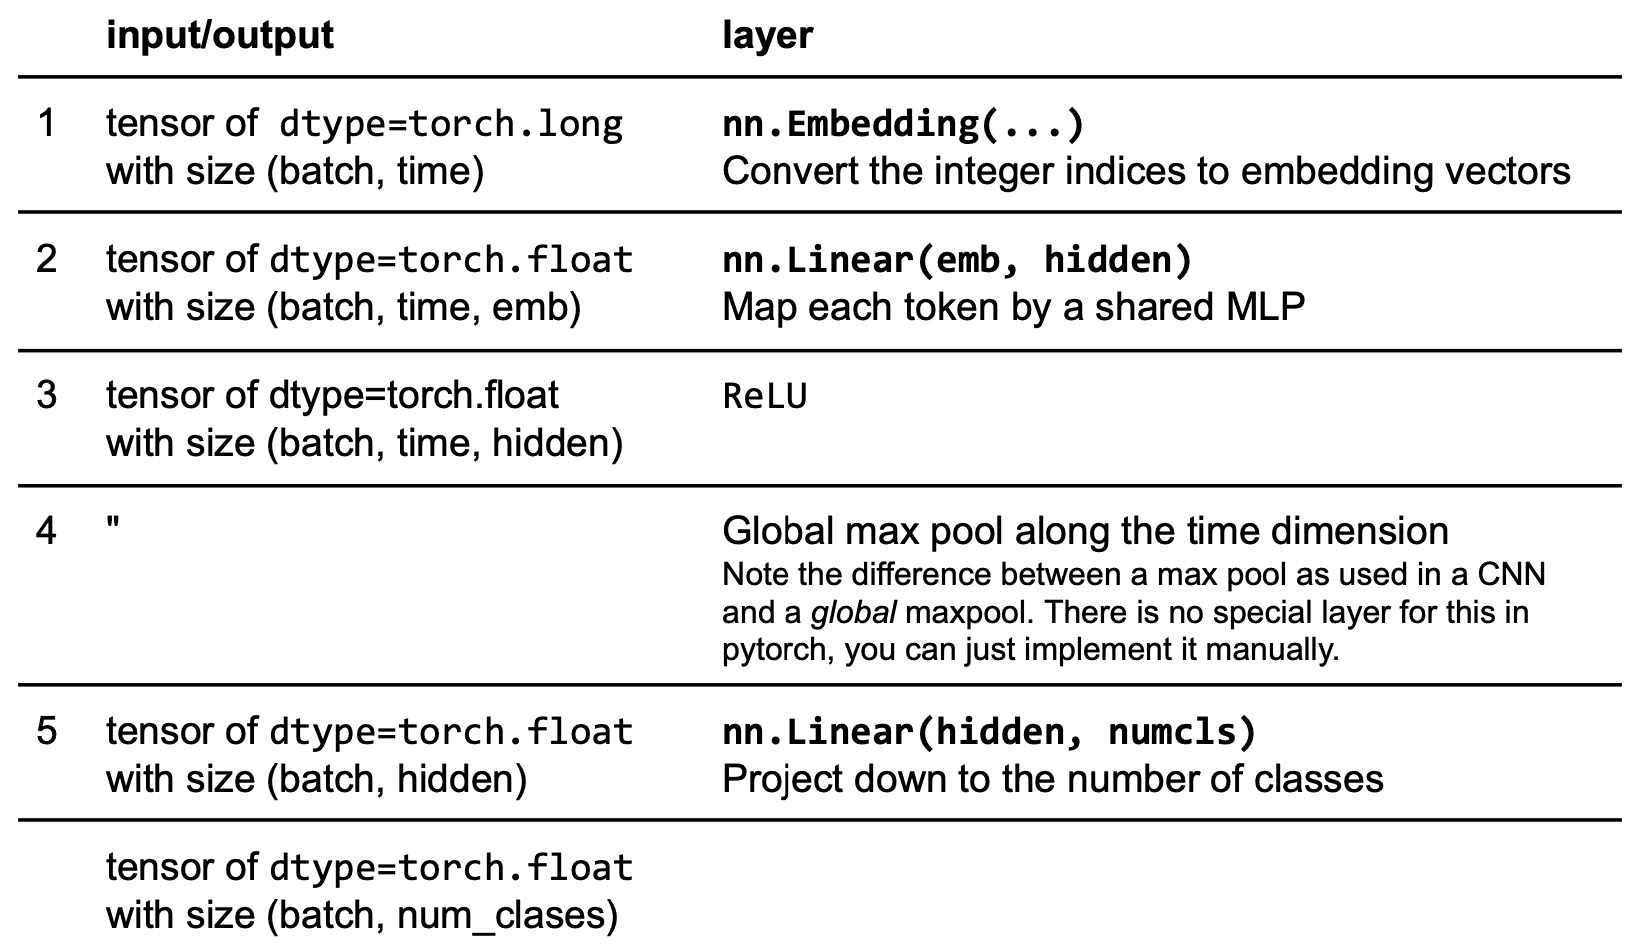

**Notes:**

*   Make sure to read the documentation for the layers used carefully
*   Use embedding size and hidden size 300.
*   The embedding layer needs to know how many tokens there are (since that is how many embedding vectors it needs to create). How can you find this from the return values of the `load_imdb` function?
*   Note that the second layer is a Linear layer, applied only to the last dimension of
three input dimensions. That is, the first two dimensions should both be treated as batch dimensions.
    *   One way to achieve this is to use reshapes (lecture 2.4) to fold the two into one dimension and then unfold them again afterward. However, if you read the documentation of `nn.Linear` carefully, you'll find that for this particular layer, there's an easier way.
*   The model is not memory-intensive, so you can easily go to large batch sizes to speed up training. Note, however, that the amount of padding also increases with the batch size. Can you explain why?
*   It's most common not to make softmax part of the model, but to apply it as part of the loss function, since this can be done in a more numerically stable way. The function `torch.nn.functional.cross_entropy` can be used to calculate the loss here. Make sure to read the documentation carefully so that you know what it expects.
    *   Note that when computing accuracy, we only need the class with the highest score, so we can just compute the argmax over the linear outputs.

### **Question 3:** Train for at least one epoch and compute the validation accuracy. It should be above 60% for most reasonable hyperparameters.

Please remember that training requires implementing a dataloader, a training loop, etc.

## **Part 3:** Writing your own Elman RNN

For a sequence-to-sequence layer that propagates information over time, we'll start with a simple Elman network (the first type of simple RNN shown in the lectures).
PyTorch has these available, but it's instructive to build our own first, to see what happens under the hood. Since this can be complicated, we'll give you some skeleton code to work from:


```
class Elman(nn.Module):

         def __init__(self, insize=300, outsize=300, hsize=300):

             super().__init__()
             self.lin1 = ...
             self.lin2 = ...
         def forward(self, x, hidden=None):
             b, t, e = x.size()
             if hidden is None:
                 hidden = torch.zeros(b, e, dtype=torch.float)
             outs = []
             for i in range(t):
                 inp = torch.cat([x[:, i, :], hidden], dim=1)
                  ...
                 outs.append(out[:, None, :])
             return torch.cat(outs, dim=1), hidden
```

### **Question 4:** Fill in the missing parts of this code. And build a second model, like the one in the previous part, but replacing the second layer with an `Elman(300, 300, 300)` layer.

* As you will see when you run the network, looping over slices of your input tensor is horribly slow (remember that every slice becomes a node in the computation graph). This is optimized a lot in the PyTorch library implementations of RNNs, but fundamentally all RNNs require some level of sequential processing.
* As we saw in the slides, the first and last hidden layers can be useful for various tricks. This is why PyTorch returns both the output sequence and the last hidden layer.
   * Remember this when you fit the Elman module into your larger network: it outputs a pair, and only the first element of that pair should be passed to the next layer.



## **Part 3:** Using Torch's RNNs

PS: This should be part 4 but the assignment labelled it wrong. To keep the rest of the document in synch with the PDF I will keep this the same.

To speed things up, let's try again with pytorch's own RNN implementations. Take the previous model and replace layer 2 with layers of the type `torch.nn.RNN` (the torch implementation of the Elman network) and `torch.nn.LSTM`, and adapt the network as necessary.

Read the documentation carefully to see what the pytorch RNNs compute. The pytorch Elman network only computes the first layer of the Elman network. This means you get the activated hidden layer out.


### **Question 5:** Tune the hyperparameters for these three models (MLP, Elman, LSTM).

* Machine Learning gospel tells us that with enough tuning, the LSTM will perform
best, followed by the Elman network, followed by the MLP. Is this what you find as well? State your hypothesis based on your chosen hyperparameters and the validation performance. Then run all three models on the test set and report your findings.
* The default dimension order in PyTorch sequence models is slightly confusing (time, batch, embedding). You can transpose the dimensions, or just pass `batch_first=True` to the constructor of your RNN.

## **Part 4:** Autoregressive models

In this final part, we will move from a sequence classification model (sequence-to-label) to a prediction model (sequence-to-sequence). The task of this model is to predict the next token in a sequence given all the tokens that precede it.

**Data:**

We will start with two simple synthetic datasets.

Load the ndfa dataset with

In [11]:
x_train, (i2w, w2i) = data_rnn.load_ndfa(n=150_000, char=True)

TypeError: ignored

Load the brackets dataset with

In [12]:
x_train, (i2w, w2i) = data_rnn.load_brackets(n=150_000, char=True)

TypeError: ignored

This will return the following objects:
* `x_train`: A list of lists of integers indices, encoding characters. Sorted from short
sequences to long sequences.
* `i2w`: A list mapping the indices to their characters
* `w2i`: A dictionary mapping the characters to their indices.

To decode a sequence, use:

In [13]:
print(''.join([i2w[i] for i in  x_train[10_000]]) )

atatimeinourculturewhererealityexposedasnarrativeisoverpoweringfictionasweknowitonthesmallandbigscreenapartfromthatisafilmthatexposesreallifemomentsthatfeelmorehonestfreshandinnovativeintherepresentationthanihaveeverseenbeforetheusualspoonfeedingconventionsarenonexistentinthisfilmleavingacontentaudiencetositandwatchthesereallifemomentstrickleoneaftertheotheronthescreenwhilewatchingthemovieandevenuponpostcontemplationitishardtobelievethattheseamazingperformanceswhereactuallythatperformanceseverymomentwiththelargecastofactorsfeltlikethetruthbeingexposedintheirdailyusuallivesevensoapartfromthatdoesnotfeellikeadocumentaryorrealitytelevisionbutinsteadtranscendsintoacategoryofitsownwithitsuniquecinematographyanddirectionilookforwardtowatchingthisnewcategoryofstorytellingcontinuewithotherfilmsbydirectorsjennifershaininandrandywalkerbrbrthismoviemustbeseen


The `ndfa` dataset contains sequences sampled from the non-deterministic finite automaton on the right.

The brackets dataset contains sequences like
()()(()), (((()))) and (()()): sequences of
parentheses that are correctly matched (a
so-called Dyck language). We will attempt to train an autoregressive LSTM to learn these grammars. We suggest starting with the NDFA data, and then moving on to the brackets.

In both cases, we will consider the learning successful if in a sample of 10 sequences, the majority is correct. This is not very strict, but it will suffice for our purposes. To check if a long string is correct for the bracket data, just check that it contains the same number of opening and closing brackets.

To load the data, we will split it into batches and pad the batches. However, before padding, we'd also like to prepend a '`.start`' token to each sequence and append an '`.end`' token (you can look up their indices in the w2i dictionary). These tokens will help the model understand where a sequence should start and end.

**Batching:**
You can split the data into batches of the same size, but then the early batches will use far less memory than the later batches. To maximise memory utilization, we recommend setting a maximum number of tokens per batch rather than a maximum number of sequences, and adding sequences to the batch until you're finished.

LSTMs can suffer from catastrophic forgetting. This means that if we train on short sequences for too long after seeing a long sequence, the model forgets what it has learned about the long sequences. A simple solution is to cut up your dataset into batches of similar-length sequences (and possibly variable size) before training and to shuffle the list of batches before the start of each epoch. That way, the model will never go too long without seeing a long sequence.

Since we're training autoregressively, the target is just the batch, shifted one token to the left. Create a target tensor by removing the first column of the input tensor and appending a column of zeros.

### **Question 6:** Set up a model with the following structure:

The number of layers should be 1, 2 or 3. Make sure to set `batch_first` to `True` if your input tensor has shape (batch, time, emb). Omitting this argument results in silent failure.

The NDFA task can be learned in three epochs with a single-layer network with e=32, h=16.

For our loss function, we want to use a cross entropy loss at every point in time. This is possible with the pytorch cross entropy loss function, but if your output tensor has size (batch, time, vocab) and your target (integer) tensor has size (batch, time), you'll need to do some shuffling of dimensions. Read the documentation carefully to figure out the details.

**Warning:** Some loss functions apply the softmax function for you, and some expect you to do it manually. Read the documentation carefully. Applying softmax twice is a very common bug.

**Sampling:** Since this task is challenging, we will forego a proper evaluation on a test/train
split. Instead, we'll sample some data from our model, and inspect it.

Start with a seed sequence of a number of integer encoded tokens. For instance:

`seq = [w2i['.start'], w2i['('], w2i['('], w2i[')']]`

Feed this sequence to the model (transform it to a tensor and add a singleton batch dimension), and observe what probabilities it predicts for the next character. That is, the probabilities from the logit vector `output[0, -1, :]`. Sample a character from this distribution and append it to the seed sequence. Repeat this process until your observe and end token, or until the sequence reaches a particular maximum length.

### **Question 7:** Generate and print 10 samples from the seed after every epoch.

For sampling from the output distribution, you can use the following function:

In [ ]:
import torch.distributions as dist
def sample(lnprobs, temperature=1.0):
  """
         Sample an element from a categorical distribution
         :param lnprobs: Outcome logits
         :param temperature: Sampling temperature. 1.0 follows the given
         distribution, 0.0 returns the maximum probability element.
         :return: The index of the sampled element.
  """
  if temperature == 0.0:
    return lnprobs.argmax()
  p = F.softmax(lnprobs / temperature, dim=0)
  cd = dist.Categorical(p)
  return cd.sample()

The temperature hyperparameter allows you to balance between sampling from the given probabilities (temp 1.0) and giving more weight to the high probability tokens. For the bracket task a low temperature is good, since we want to see if the model has learned to generate only correct sentences.


### **Question 8:** Train an autoregressive model. This can be a challenging training task, even on toy data. Make sure to plot your loss curves and gradient norm curves. Gradient clipping is very likely to help (this is true in general for RNNs).

* We strongly recommend tensorboard for plotting loss curves in this exercise.
* Once you have a smoothly decaying loss curve over the first 10 or so epochs, you'll
have to let the model run for around 50 or so epochs to see real progress.
* Make sure to compute the loss per token, so that the batch size and instance length don't affect the smoothness of the loss curve. Pass `reduction='sum'` to the loss function, and divide by the number of tokens manually.
* It's common to implement masking, so that the loss is only computed over the non-padded elements of the batch. You can do this by passing a weight tensor to the cross-entropy function. This is not crucial for the task, since it's relatively simple for the network to learn that an .end token is always followed by a string of .pad tokens. Consult the documentation of the cross-entropy loss to see how to do this.